In [ ]:
!pip install kora -q
from kora import drive
drive.link_nbs()

     |████████████████████████████████| 57 kB 2.4 MB/s 
     |████████████████████████████████| 60 kB 2.1 MB/s 
Mounted at /content/drive


In [ ]:
import utils

importing Jupyter notebook from /nbs/utils.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.applications.efficientnet import EfficientNetB0
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Input, MaxPooling3D, LSTM, Dense, Conv3D, Conv2D, BatchNormalization, Flatten, Dropout, Convolution2D, Activation, MaxPooling2D, GlobalAveragePooling2D, concatenate, Reshape, AveragePooling2D, Add
from keras import losses
from tensorflow import keras
from tensorflow import Tensor

In [ ]:
""" GLOBAL VARIABLES """
NUM_CLASSES = 4
EPOCHS = 10
INSTACK = 16
IMG_SIZE = (224, 224)
LEN_TRAIN = 85

In [ ]:
""" Data loading """

train_gen = utils.joinedGens(Train=True, needDirectories=True)
val_gen = utils.joinedGens(Val=True)

--2022-04-20 15:19:02--  http://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz [following]
--2022-04-20 15:19:02--  https://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163535078 (156M) [application/x-gzip]
Saving to: ‘tv_human_interactions_videos.tar.gz’

tv_human_interactio 100%[===================>] 155.96M  32.8MB/s    in 5.3s    

2022-04-20 15:19:08 (29.2 MB/s) - ‘tv_human_interactions_videos.tar.gz’ saved [163535078/163535078]

--2022-04-20 15:19:08--  http://www.robots.ox.ac.uk/~alonso/data/readme

In [ ]:
TVHI_trained = "/content/drive/MyDrive/Colab Notebooks/TFLModel_1"
OF_trained = "/content/drive/MyDrive/Colab Notebooks/OF_model"

In [ ]:
""" Small function to change names in model to make it work as a TS model"""
def changeLayerNames(model, model_name):
  
  if model_name == "resnet_base": 
    for i in range(len(model.layers)):
      if "batch_normalization" in model.layers[i]._name:
        model.layers[i]._name = "BN_ResNet_"+str(i)
      if "conv2d" in model.layers[i]._name:
        model.layers[i]._name = "conv2d_ResNet_"+str(i)



In [ ]:
""" Building Model """

#Baseline model to keep expanding based on example from: https://keras.io/guides/training_with_built_in_methods/#passing-data-to-multiinput-multioutput-models
def build_TS_model():

  
  #Freeze baseline models. Set new layers to trainable. Train. Save weights and model. 
  resnet_base = keras.models.load_model(TVHI_trained)
  changeLayerNames(resnet_base, "resnet_base")


  BaseResNet = Model(resnet_base.inputs, resnet_base.layers[-5].output, name='resnet_base')
  BaseResNet.trainable = False
  BaseResNet.summary()


  of_base = keras.models.load_model(OF_trained)
  b_inputs = of_base.inputs
  b_outputs = of_base.layers[-9].output
  x = Reshape((14, 14, 128))(b_outputs) 
  OF_Base = Model(b_inputs, x, name='of_base')
  OF_Base.trainable = False
  OF_Base.summary()
  

  x = concatenate([OF_Base.output, BaseResNet.output])

  x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation = 'relu')(x)
  x = BatchNormalization(name="BN1")(x)
  x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
  
  x = Flatten()(x)
  x = Dense(256, activation = 'relu')(x)
  x = BatchNormalization(name="BN2")(x)
  x = Dropout(0.2, name="DO_1")(x)

  x = Dense(64, activation='relu')(x)
  x = BatchNormalization(name="BN3")(x)
  x = Dropout(0.2, name = "DO_2")(x)
  
  x = Dense(NUM_CLASSES, activation='softmax')(x)

  model = keras.Model(
      inputs=[OF_Base.input, BaseResNet.input], outputs=x)
  model.compile(loss= [keras.losses.CategoricalCrossentropy(from_logits=True),keras.losses.CategoricalCrossentropy(from_logits=True)], optimizer='Adam', metrics=['accuracy'])
  model.summary()

  return model 


In [ ]:
ts_model = build_TS_model() 

Model: "resnet_base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 BN_ResNet_1 (BatchNormalizatio  (None, 224, 224, 3)  12         ['input_5[0][0]']                
 n)                                                                                               
                                                                                                  
 conv2d_ResNet_2 (Conv2D)       (None, 224, 224, 16  448         ['BN_ResNet_1[0][0]']            
                                )                                                       

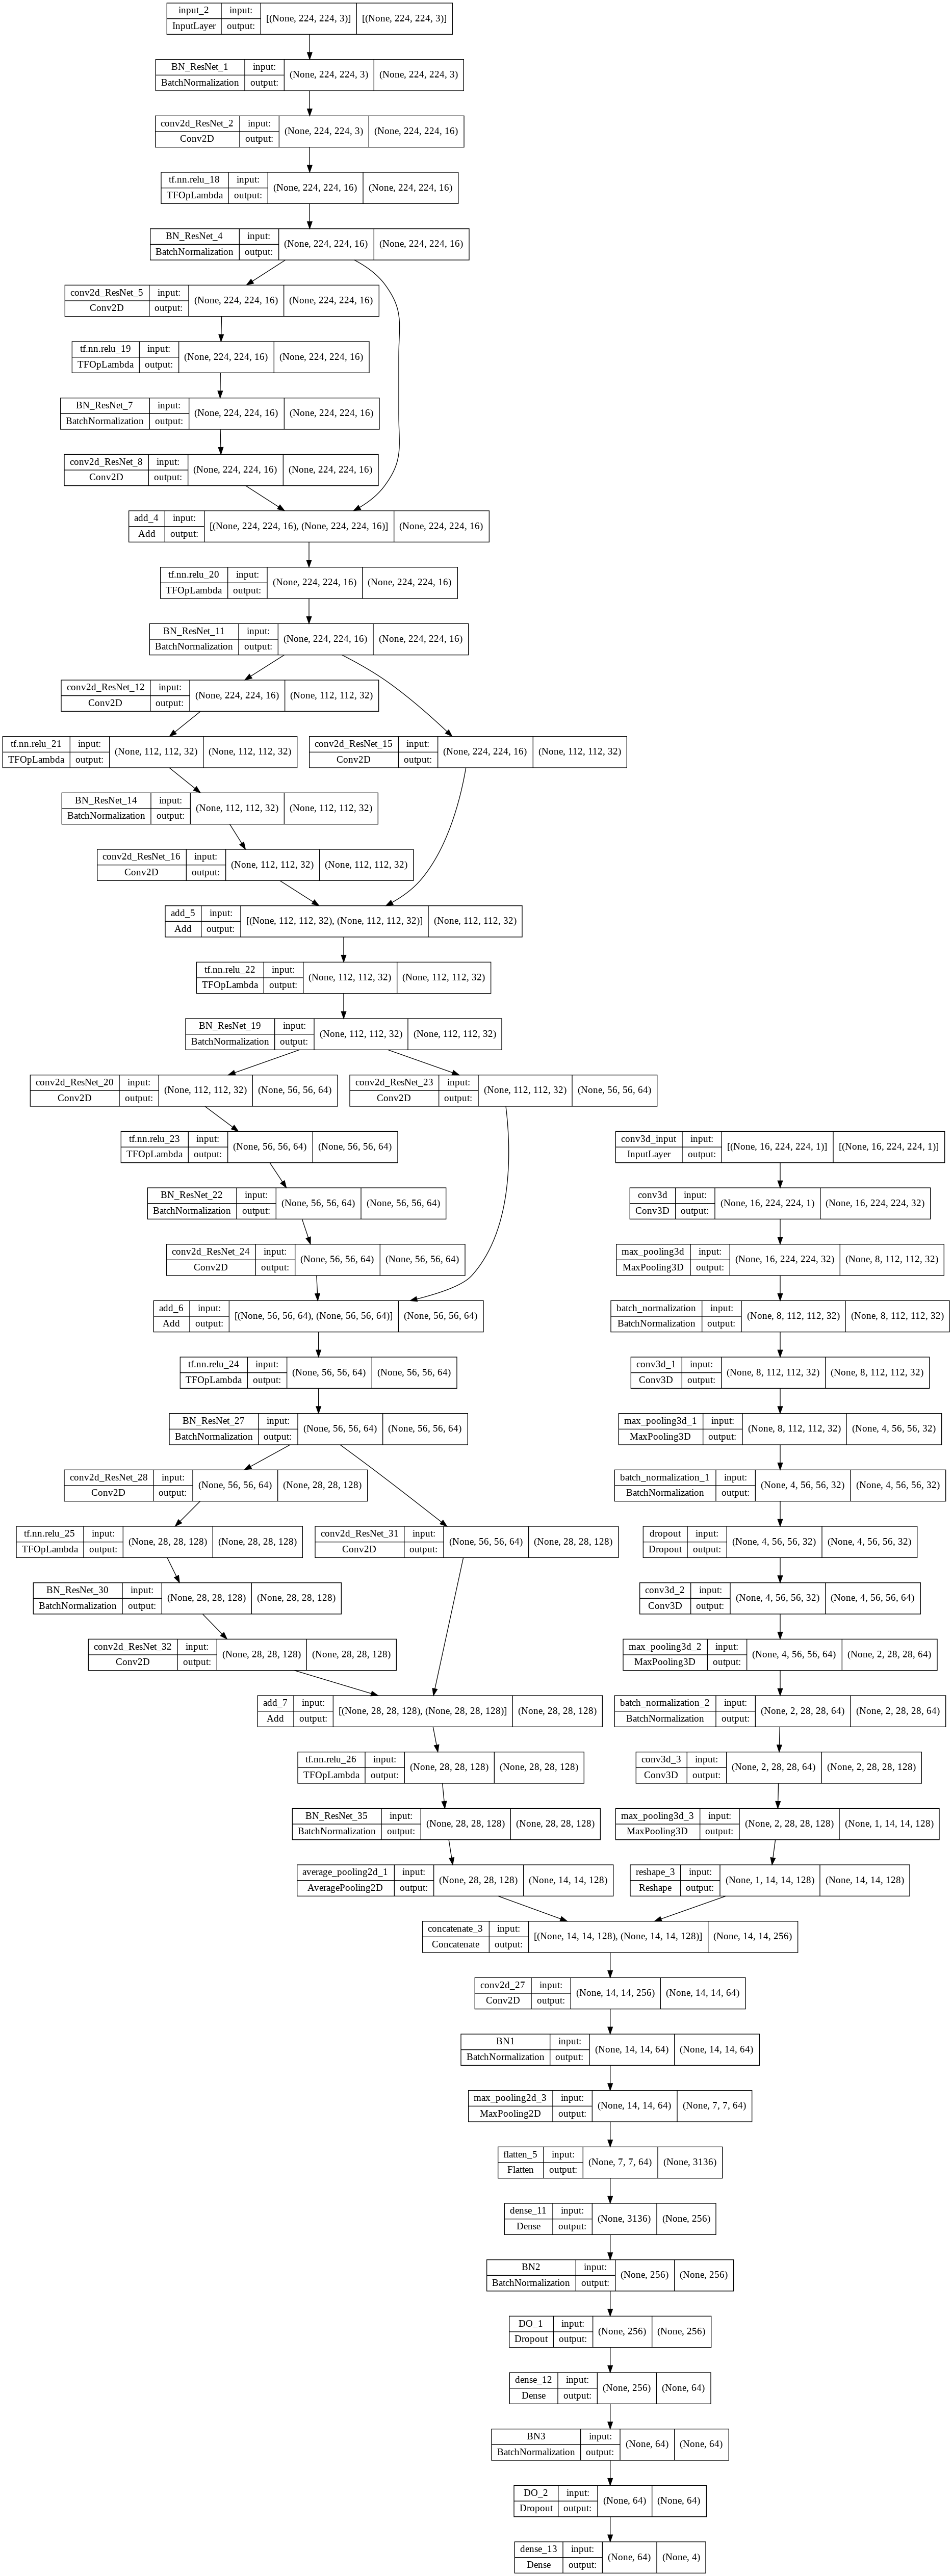

In [ ]:
""" Plot the model """
keras.utils.plot_model(ts_model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
""" Set up callback and perform training """
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

ts_history = ts_model.fit(train_gen,epochs= EPOCHS, steps_per_epoch = LEN_TRAIN, validation_data=val_gen, validation_steps=15, callbacks= callback, verbose=1)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

error reading file:  None
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

error reading file:  None
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

error reading file:  None
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

error reading file:  None
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

error reading file:  None
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

error reading file:  None
OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-2

ValueError: ignored

In [ ]:
""" Plotting results """
utils.plotAccuracy("Accuracy Optical Flow model", ts_history.history['accuracy'], ts_history.history['val_accuracy'])
utils.plotLoss("Loss Optical Flow model", ts_history.history['loss'], ts_history.history['val_loss'])

In [ ]:
""" Save model and weights """
ts_model.save_weights('TS_weights.h5')
ts_model.save("TS_model", save_format = 'tf', include_optimizer=True)